# =============================================================
# MILESTONE 1: Data Collection, Exploration, and Preprocessing
# =============================================================

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Set plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# ========================
# 1. DATA COLLECTION
# ========================

In [3]:
url = "https://raw.githubusercontent.com/Reemsoliiman/customer-churn-prediction-analysis/main/data/raw/churn-bigml-80.csv"
df = pd.read_csv(url)
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")


Dataset loaded: 2666 rows, 20 columns


In [4]:
df_before = df.copy()

# ========================
# 2. INITIAL DATA EXPLORATION
# ========================

In [5]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      2666 non-null   

In [7]:
df.isnull().sum()

State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
dtype: int64

In [8]:
print(df.duplicated().sum())

0


In [9]:
df.describe()

,Account length,Area code,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
count,2666.000000,2666.000000,2666.000000,2666.00000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000
mean,100.620405,437.438860,8.021755,179.48162,100.310203,30.512404,200.386159,100.023631,17.033072,201.168942,100.106152,9.052689,10.237022,4.467367,2.764490,1.562641
std,39.563974,42.521018,13.612277,54.21035,19.988162,9.215733,50.951515,20.161445,4.330864,50.780323,19.418459,2.285120,2.788349,2.456195,0.752812,1.311236
min,1.000000,408.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,43.700000,33.000000,1.970000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,408.000000,0.000000,143.40000,87.000000,24.380000,165.300000,87.000000,14.050000,166.925000,87.000000,7.512500,8.500000,3.000000,2.300000,1.000000
50%,100.000000,415.000000,0.000000,179.95000,101.000000,30.590000,200.900000,100.000000,17.080000,201.150000,100.000000,9.050000,10.200000,4.000000,2.750000,1.000000
75%,127.000000,510.000000,19.000000,215.90000,114.000000,36.700000,235.100000,114.000000,19.980000,236.475000,113.000000,10.640000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,50.000000,350.80000,160.000000,59.640000,363.700000,170.000000,30.910000,395.000000,166.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [10]:
df['Churn'].value_counts()

Churn
False    2278
True      388
Name: count, dtype: int64

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16048\2770794102.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='Set2')


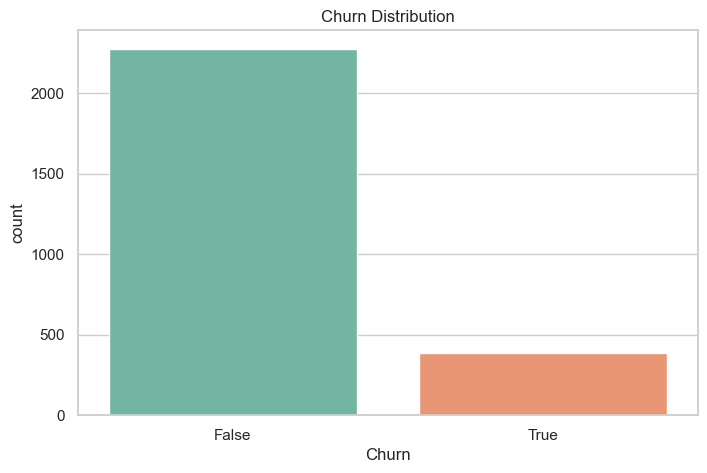

In [11]:
# Churn Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Churn', data=df, palette='Set2')
plt.title('Churn Distribution')
plt.show()

# ========================
# 3. DATA CLEANING & PREPROCESSING
# ========================

# -------------------------------------
# 3.1 Remove Duplicates
# -------------------------------------

In [12]:
if df.duplicated().sum() > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print(f"Removed {df.duplicated().sum()} duplicates")
else:
    print("No duplicates found")

No duplicates found


# -------------------------------------
# 3.2 Handle Missing Values
# -------------------------------------

In [13]:
if df.isnull().sum().sum() > 0:
    print("Missing values found")
else:
    print("No missing values found")

No missing values found


# -------------------------------------
# 3.3 Outlier Detection & Clipping
# -------------------------------------

In [14]:
numeric_cols = [
    'Total day minutes', 'Total day charge', 
    'Total eve minutes', 'Total eve charge',
    'Total night minutes', 'Total night charge', 
    'Total intl minutes', 'Total intl charge',
    'Account length'
]

In [15]:
outlier_counts = {}
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers before clipping
    outlier_counts[col] = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    
    # Clip values
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

print("Outliers detected before clipping:")
for col, count in outlier_counts.items():
    print(f"  {col}: {count} outliers")
print("Outliers clipped to IQR bounds")

Outliers detected before clipping:
  Total day minutes: 21 outliers
  Total day charge: 21 outliers
  Total eve minutes: 17 outliers
  Total eve charge: 17 outliers
  Total night minutes: 22 outliers
  Total night charge: 22 outliers
  Total intl minutes: 37 outliers
  Total intl charge: 40 outliers
  Account length: 12 outliers
Outliers clipped to IQR bounds


# -------------------------------------
# 3.4 Feature Engineering
# -------------------------------------

In [16]:
df['Total_Charge'] = (
    df['Total day charge'] + df['Total eve charge'] + 
    df['Total night charge'] + df['Total intl charge']
)
df['Total_Minutes'] = (
    df['Total day minutes'] + df['Total eve minutes'] + 
    df['Total night minutes'] + df['Total intl minutes']
)

In [17]:
df['Avg_Minute_Cost'] = df['Total_Charge'] / df['Total_Minutes'].replace(0, np.nan)
df['Avg_Minute_Cost'] = df['Avg_Minute_Cost'].fillna(df['Avg_Minute_Cost'].median())

In [18]:
df['Total_Calls'] = (
    df['Total day calls'] + df['Total eve calls'] + 
    df['Total night calls'] + df['Total intl calls']
)

In [19]:
df['High_Customer_Service'] = (df['Customer service calls'] > 3).astype(int)  # Binary feature
df['Account_Length_Binned'] = pd.qcut(df['Account length'], q=3, labels=['Short', 'Medium', 'Long'])

In [20]:
print("New features created: 'Total_Charge', 'Total_Minutes', 'Avg_Minute_Cost', 'Total_Calls', 'High_Customer_Service', 'Account_Length_Binned'")

New features created: 'Total_Charge', 'Total_Minutes', 'Avg_Minute_Cost', 'Total_Calls', 'High_Customer_Service', 'Account_Length_Binned'


In [21]:
print(df[['Total_Charge', 'Total_Minutes', 'Avg_Minute_Cost', 'Total_Calls', 'High_Customer_Service', 'Account_Length_Binned']].describe())

       Total_Charge  Total_Minutes  Avg_Minute_Cost  Total_Calls  \
count   2666.000000    2666.000000      2666.000000  2666.000000   
mean      59.377417     591.334565         0.100333   304.907352   
std       10.405702      89.561694         0.008325    34.421404   
min       27.020000     284.300000         0.067958   191.000000   
25%       52.287500     530.325000         0.094833   282.000000   
50%       59.355000     593.950000         0.100300   305.000000   
75%       66.557500     653.000000         0.105935   328.000000   
max       92.370000     862.850000         0.129791   416.000000   

       High_Customer_Service  
count             2666.00000  
mean                 0.07877  
std                  0.26943  
min                  0.00000  
25%                  0.00000  
50%                  0.00000  
75%                  0.00000  
max                  1.00000  


# -------------------------------------
# 3.5 Encode Target & Categoricals
# -------------------------------------

In [22]:
# Convert Churn (boolean) to 0/1
df['Churn'] = df['Churn'].astype(int)
print("Churn converted to 0/1")

Churn converted to 0/1


In [23]:
# Convert Area code to string for categorical encoding
df['Area code'] = df['Area code'].astype(str)

In [24]:
# One-hot encode categorical columns
categorical_cols = ['State', 'Area code', 'International plan', 'Voice mail plan', 'Account_Length_Binned']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print(f"One-hot encoded {len(categorical_cols)} categorical columns")
print(f"Final dataset shape: {df_encoded.shape}")

One-hot encoded 5 categorical columns
Final dataset shape: (2666, 77)


In [25]:
# Save cleaned dataset
df_encoded.to_csv('../data/processed/cleaned_data.csv', index=False)
print("Cleaned dataset saved")

Cleaned dataset saved


# ========================
# 4. EXPLORATORY DATA ANALYSIS (VISUALIZATIONS)
# ========================

In [26]:
numeric_cols = [
    'Total day minutes', 'Total day charge', 'Total eve minutes', 'Total eve charge',
    'Total night minutes', 'Total night charge', 'Total intl minutes', 'Total intl charge',
    'Account length', 'Number vmail messages', 'Total day calls', 'Total eve calls',
    'Total night calls', 'Total intl calls', 'Customer service calls',
    'Total_Charge', 'Total_Minutes', 'Avg_Minute_Cost', 'Total_Calls'
]

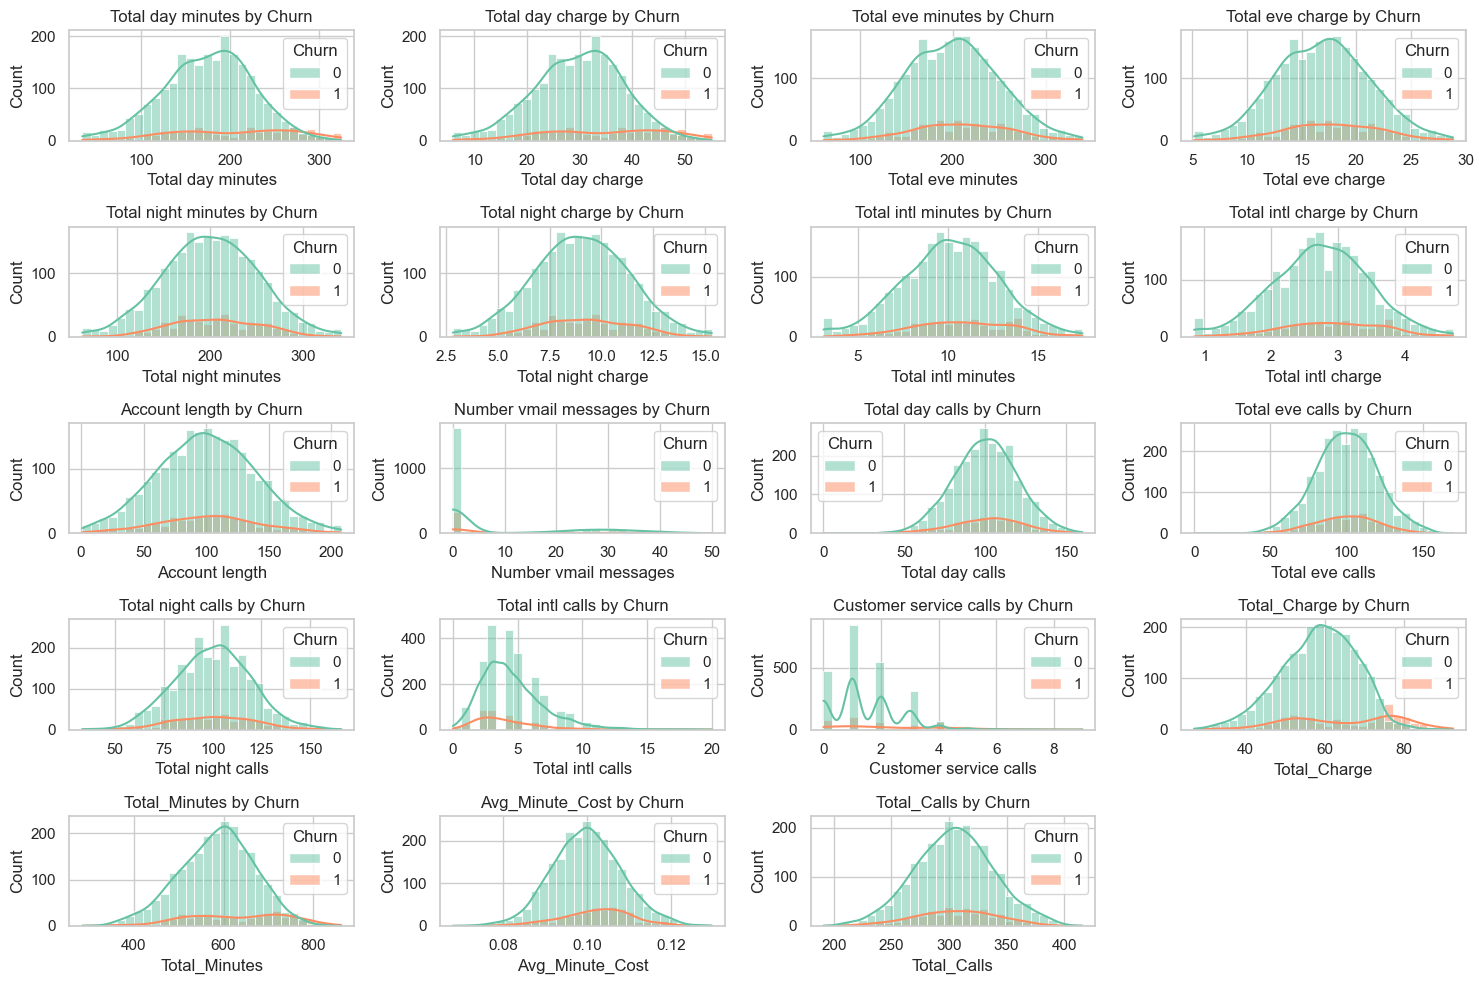

In [27]:
# 1. Histograms for Numerical Columns by Churn
plt.figure(figsize=(15, 10))
n_cols = 4 
n_rows = int(np.ceil(len(numeric_cols) / n_cols))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(data=df, x=col, hue='Churn', kde=True, bins=30, palette='Set2', alpha=0.5)
    plt.title(f'{col} by Churn')
plt.tight_layout()
plt.show()

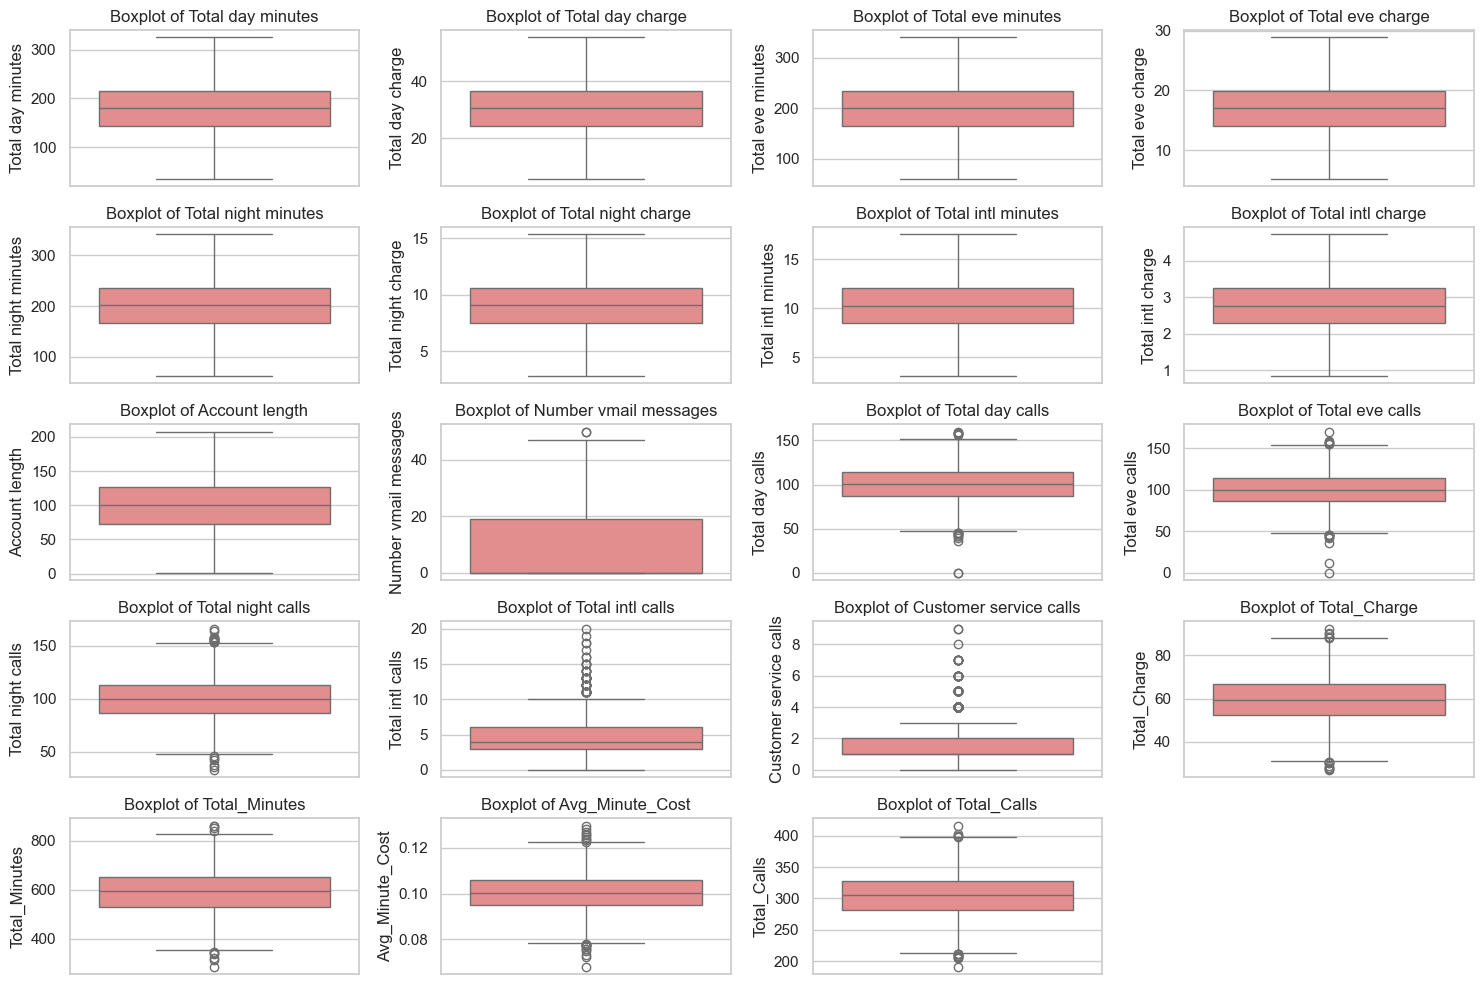

In [28]:
# 2. Boxplots for Numerical Columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(y=df[col], color='lightcoral')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16048\972027060.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df, palette='Set2')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16048\972027060.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df, palette='Set2')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16048\972027060.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df, palette='Set2')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16048\972027060.py:5: FutureWarnin

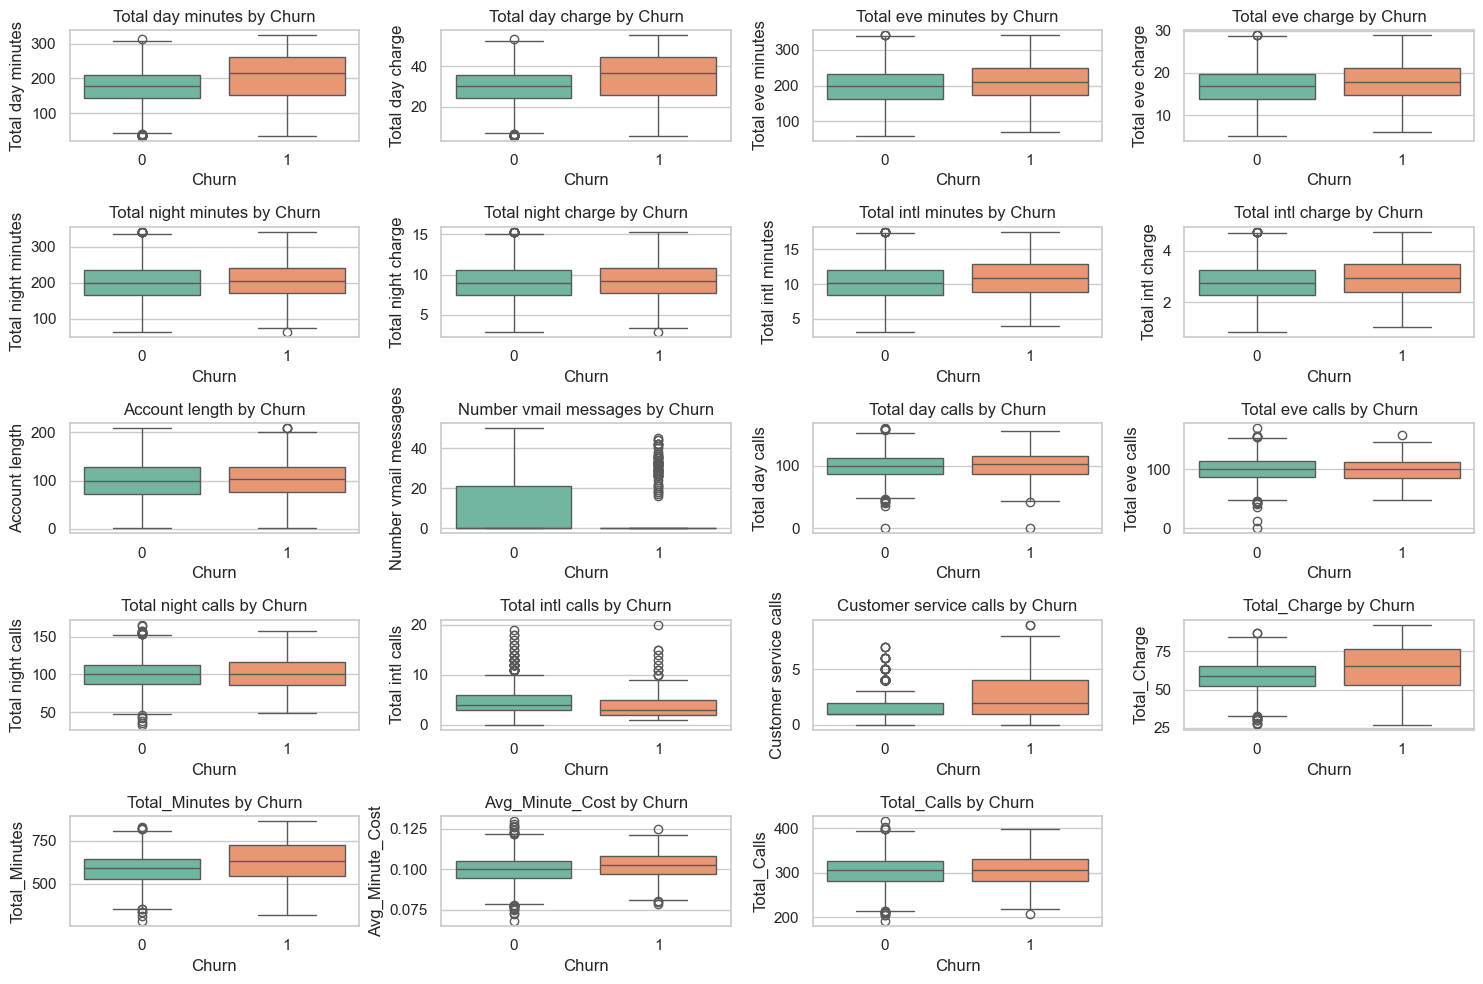

In [29]:
# 3. Boxplots by Churn
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x='Churn', y=col, data=df, palette='Set2')
    plt.title(f'{col} by Churn')
plt.tight_layout()
plt.show()

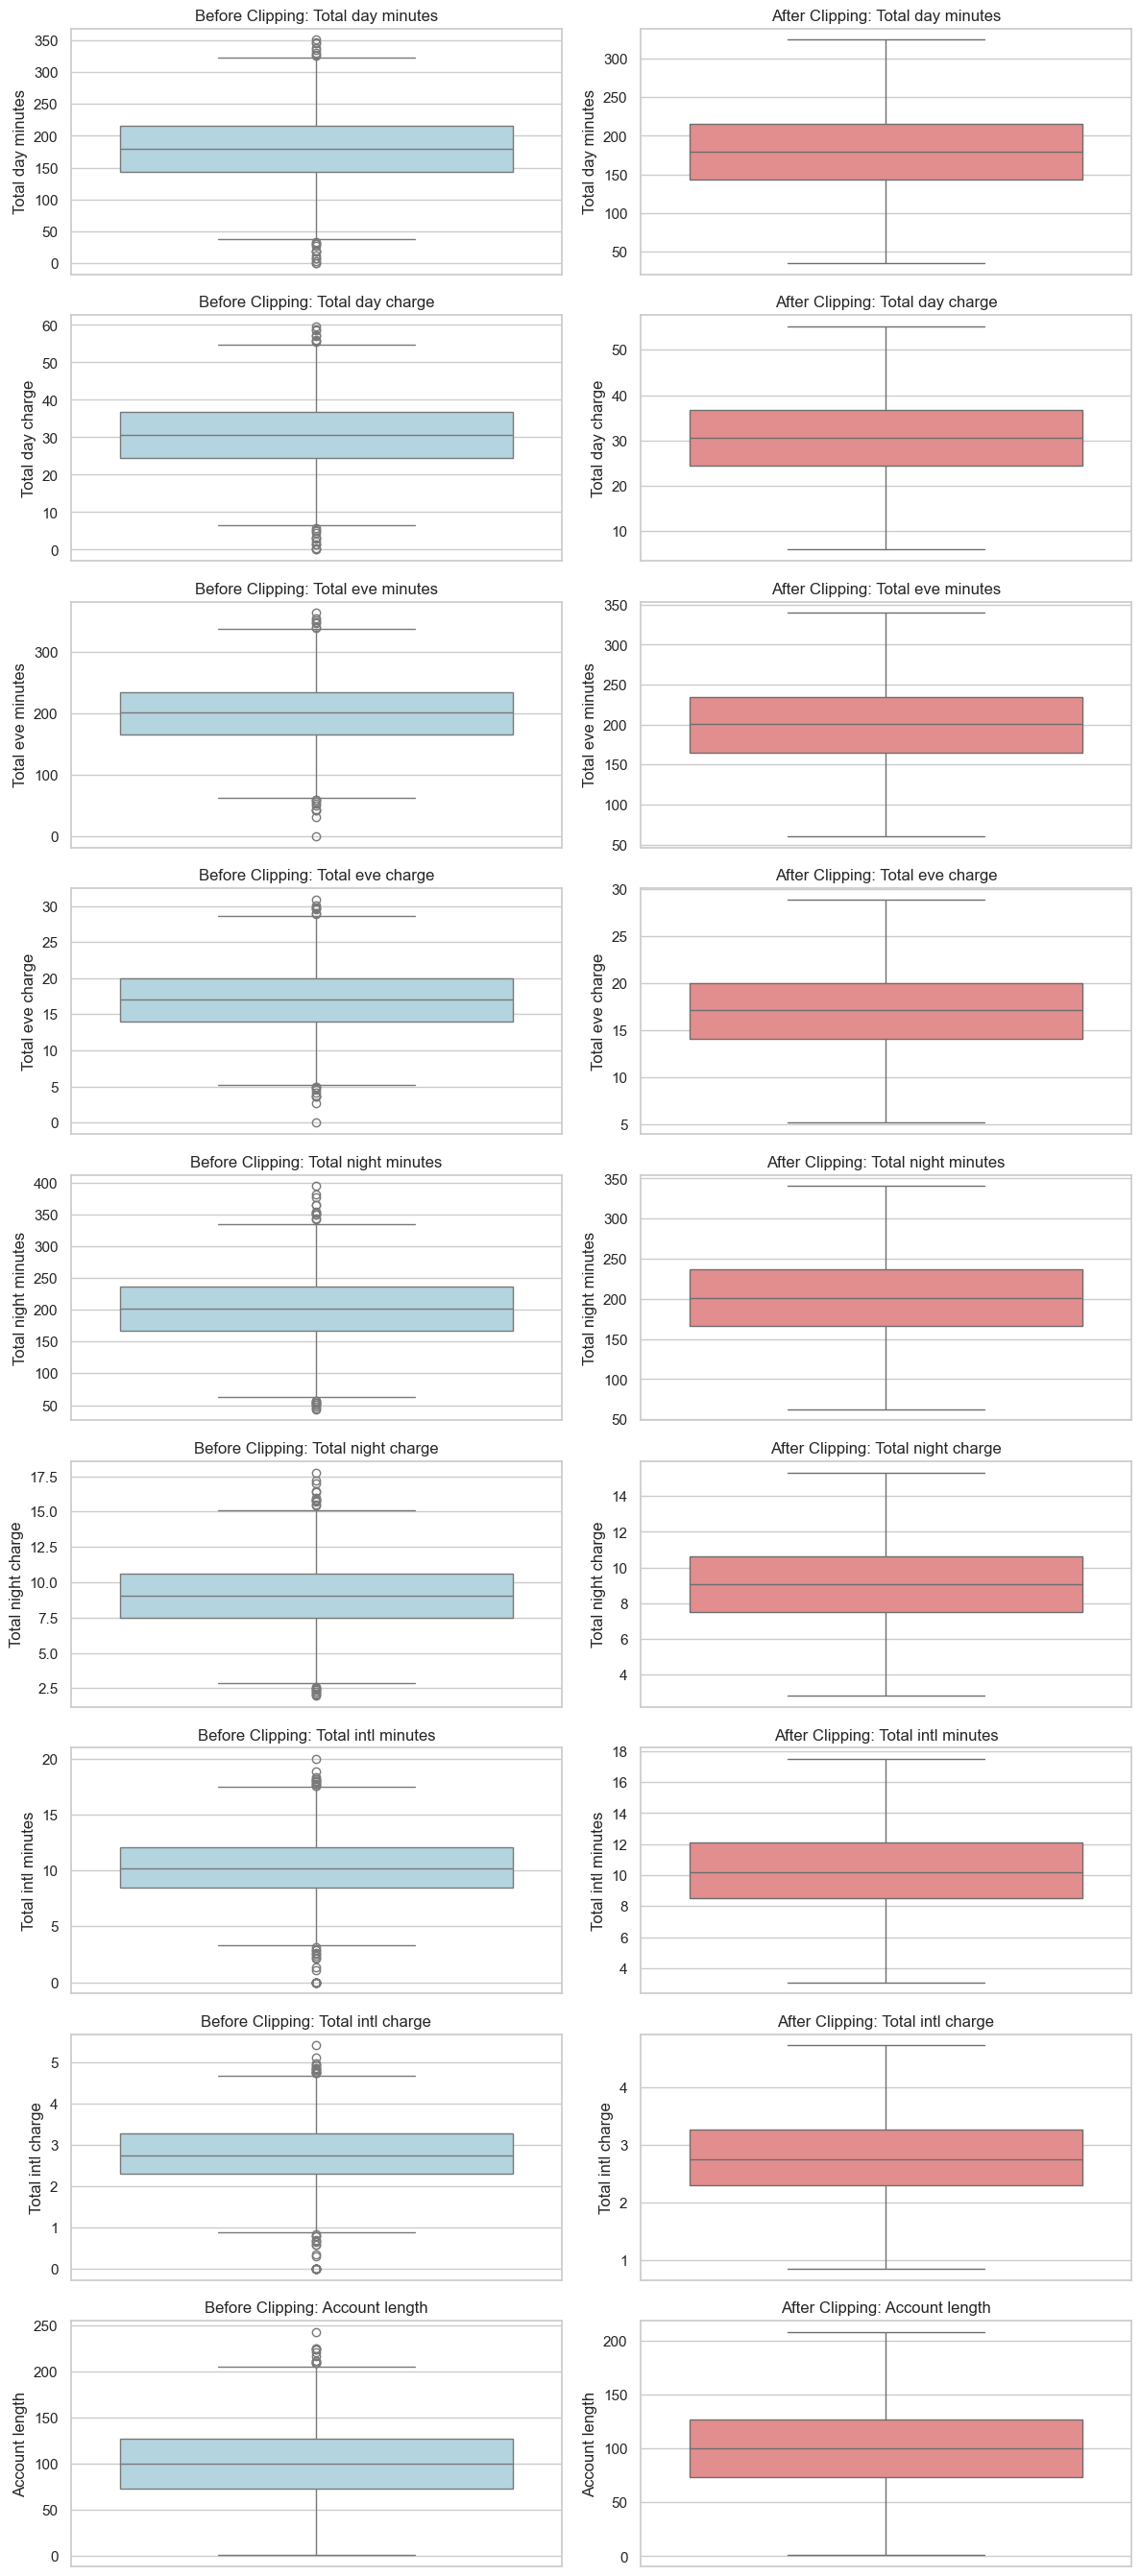

In [30]:
# 4. Side-by-Side Boxplots: Before vs. After Clipping
clipped_cols = [
    'Total day minutes', 'Total day charge', 'Total eve minutes', 'Total eve charge',
    'Total night minutes', 'Total night charge', 'Total intl minutes', 'Total intl charge',
    'Account length'
]

plt.figure(figsize=(12, len(clipped_cols) * 3))
for i, col in enumerate(clipped_cols, 1):
    plt.subplot(len(clipped_cols), 2, 2*i-1)
    sns.boxplot(y=df_before[col], color='lightblue')
    plt.title(f'Before Clipping: {col}')
    plt.subplot(len(clipped_cols), 2, 2*i)
    sns.boxplot(y=df[col], color='lightcoral')
    plt.title(f'After Clipping: {col}')
plt.tight_layout()
plt.show()

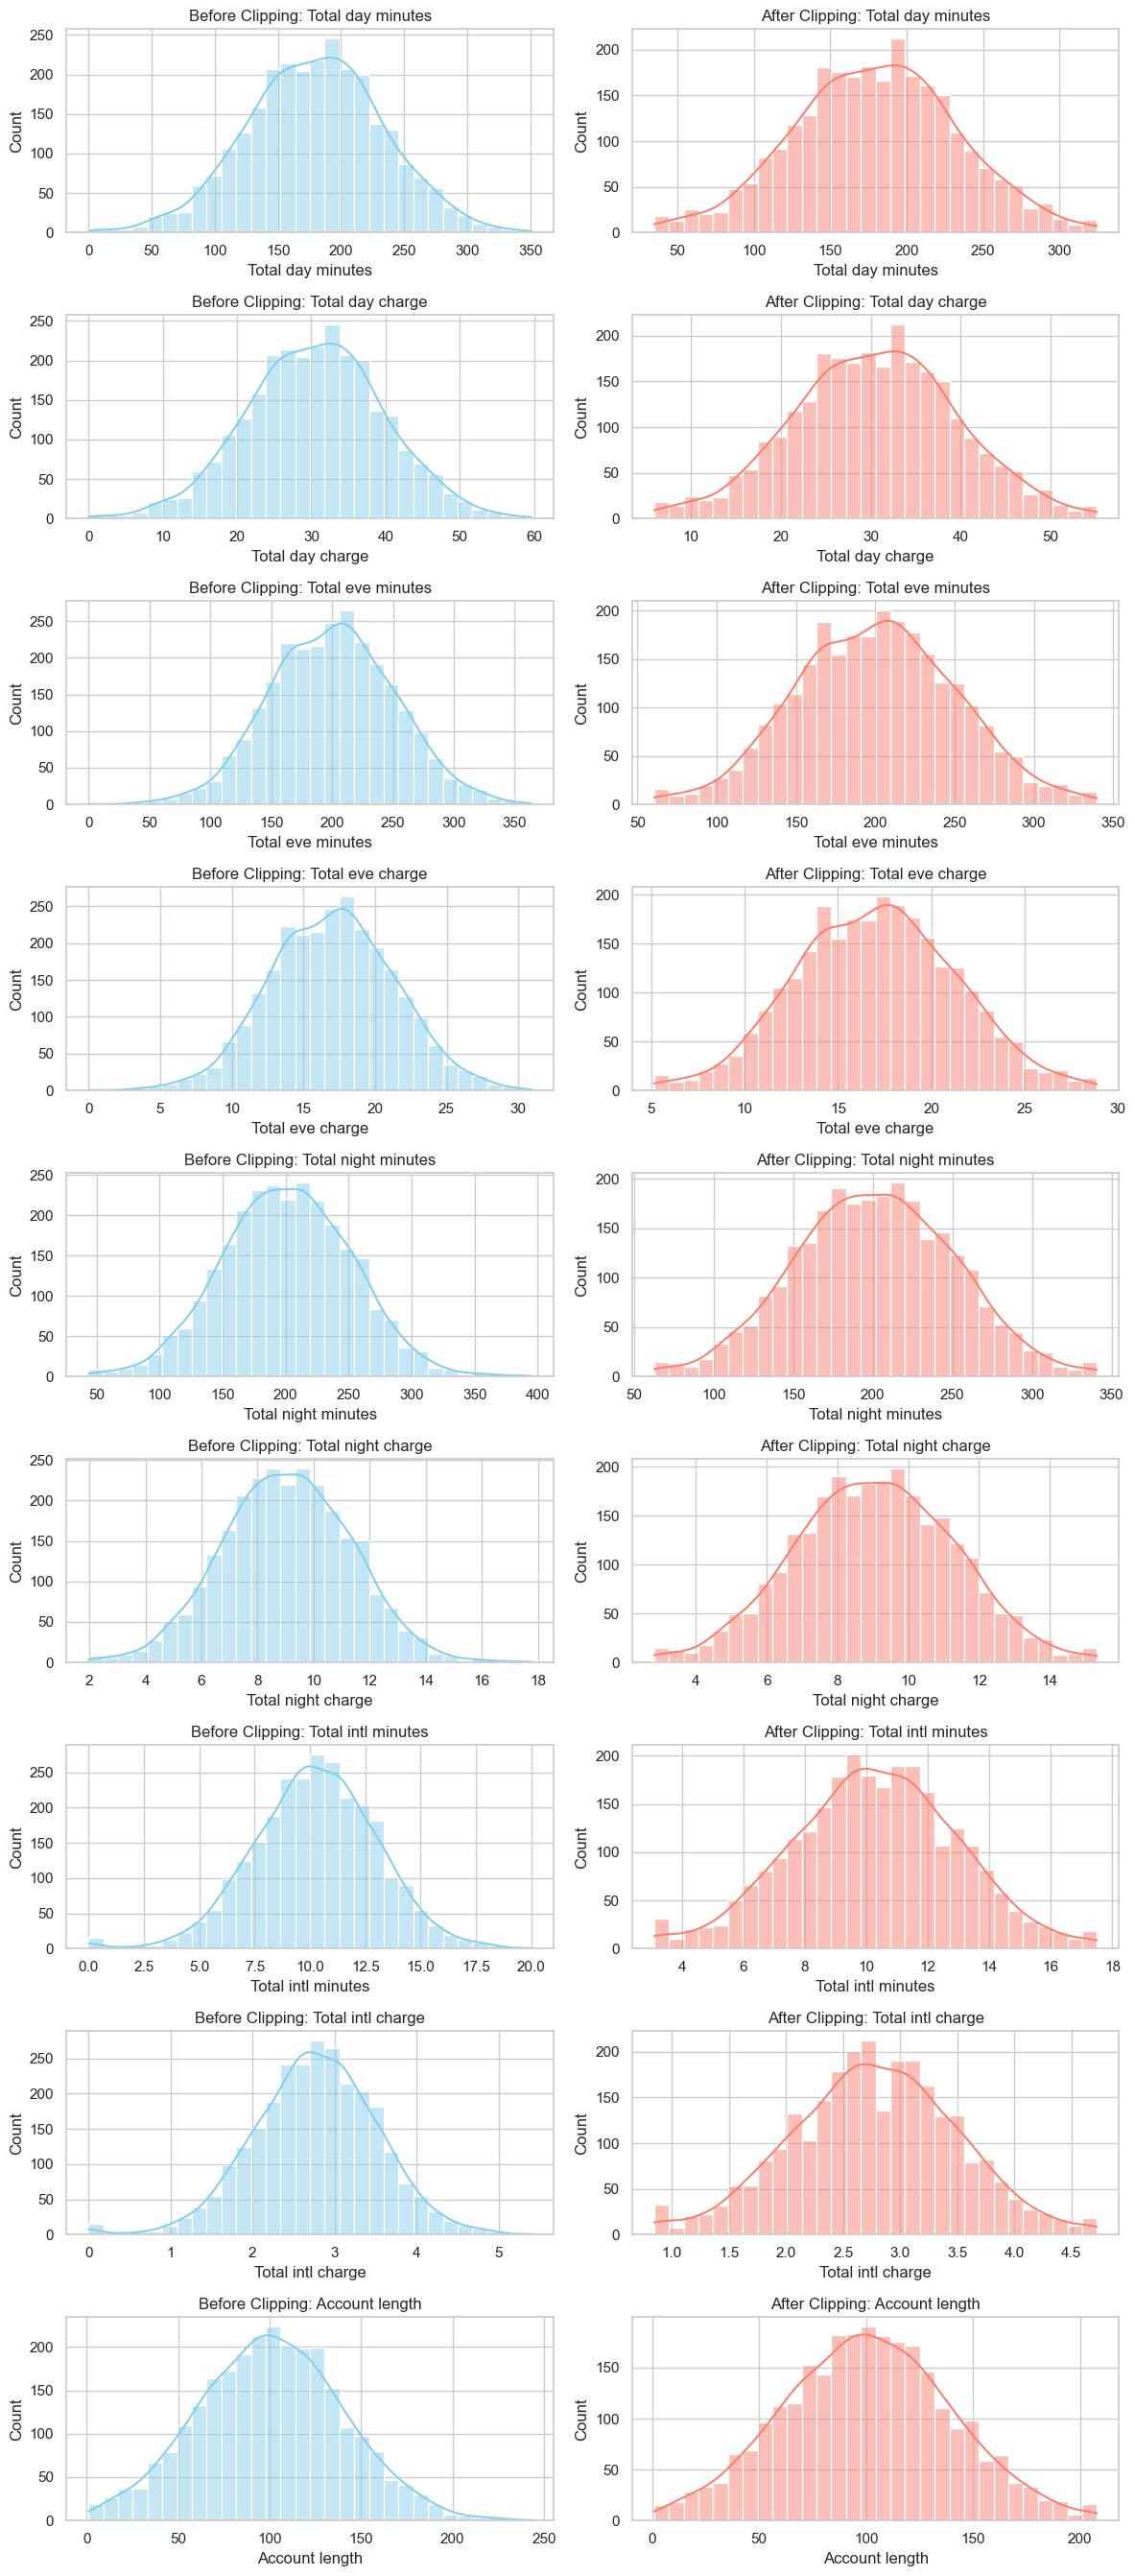

In [31]:
# 5. Side-by-Side Histograms: Before vs. After Clipping
plt.figure(figsize=(12, len(clipped_cols) * 3))
for i, col in enumerate(clipped_cols, 1):
    plt.subplot(len(clipped_cols), 2, 2*i-1)
    sns.histplot(df_before[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Before Clipping: {col}')
    plt.subplot(len(clipped_cols), 2, 2*i)
    sns.histplot(df[col], kde=True, bins=30, color='salmon')
    plt.title(f'After Clipping: {col}')
plt.tight_layout()
plt.show()

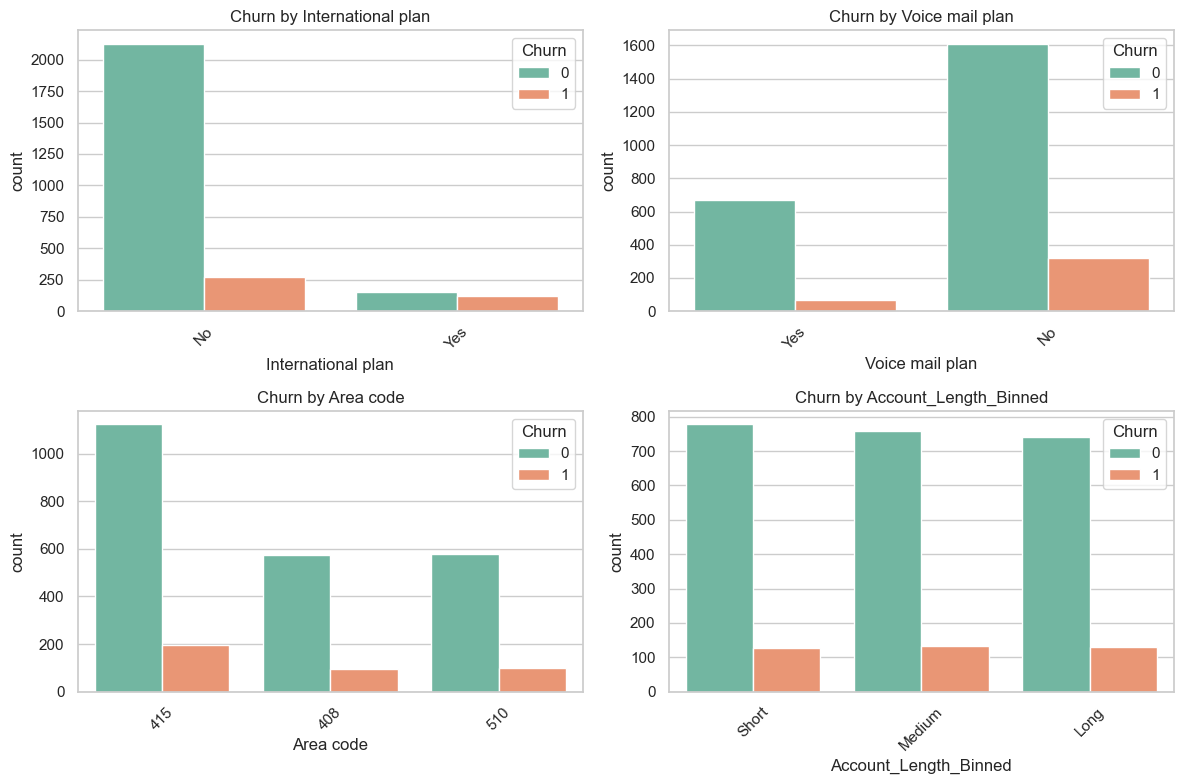

In [32]:
# 6. Categorical Variables vs. Churn
categorical_cols = ['International plan', 'Voice mail plan', 'Area code', 'Account_Length_Binned']
plt.figure(figsize=(12, 8))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=col, hue='Churn', data=df, palette='Set2')
    plt.title(f'Churn by {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

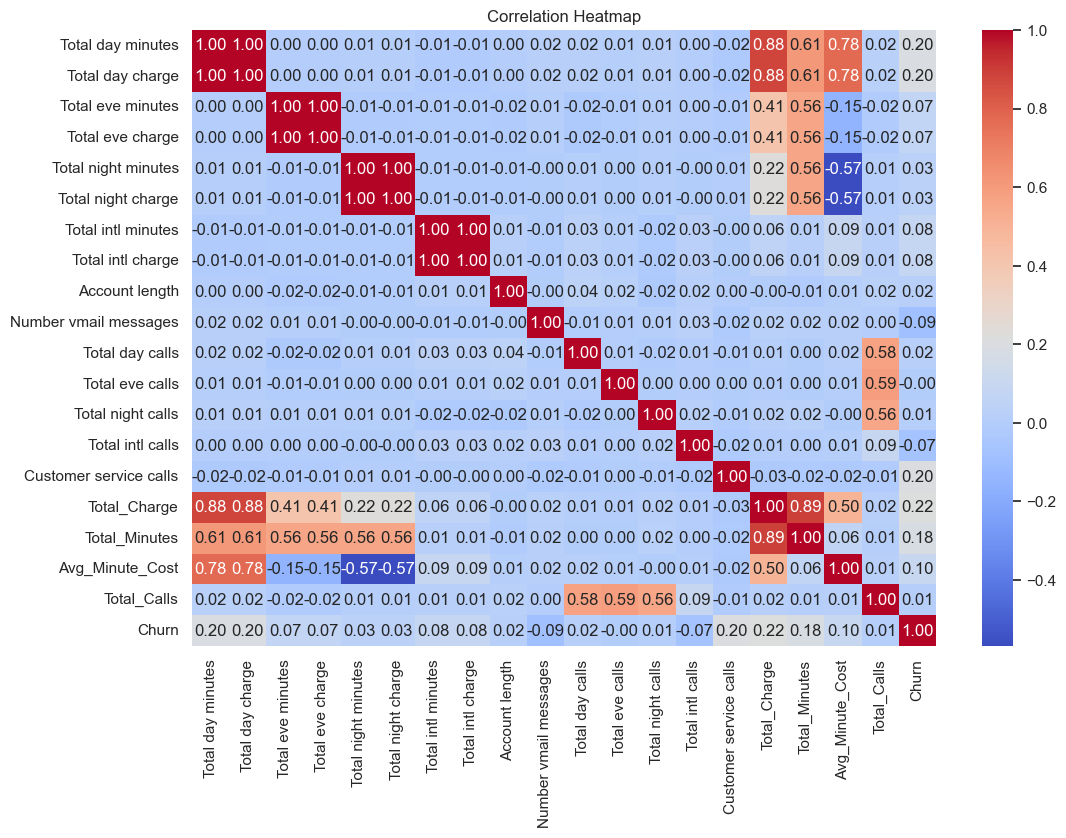

In [33]:
# 7. Correlation Heatmap
plt.figure(figsize=(12, 8))
correlation = df[numeric_cols + ['Churn']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16048\2239568192.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_churn.values, y=state_churn.index, palette='Set2')


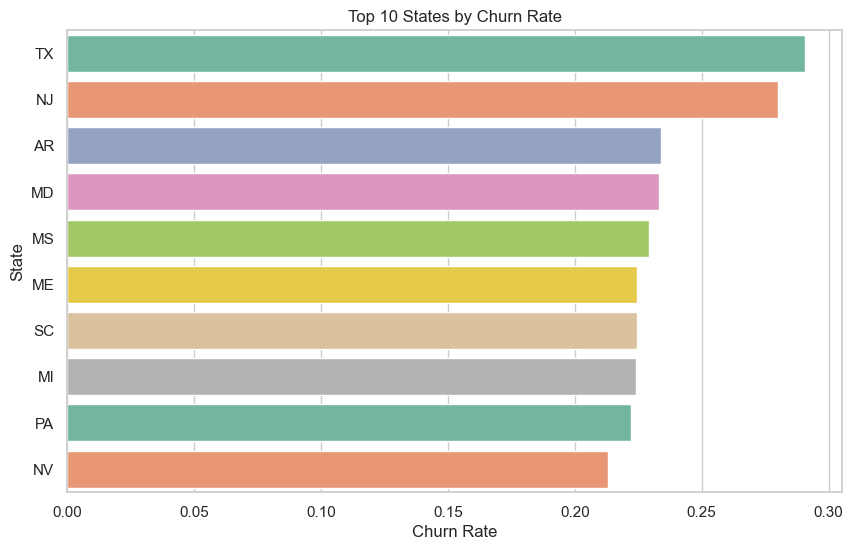

In [34]:
# 8. Churn Rate by State (Top 10 States by Count)
state_churn = df.groupby('State')['Churn'].mean().sort_values(ascending=False)[:10]
plt.figure(figsize=(10, 6))
sns.barplot(x=state_churn.values, y=state_churn.index, palette='Set2')
plt.title('Top 10 States by Churn Rate')
plt.xlabel('Churn Rate')
plt.show()

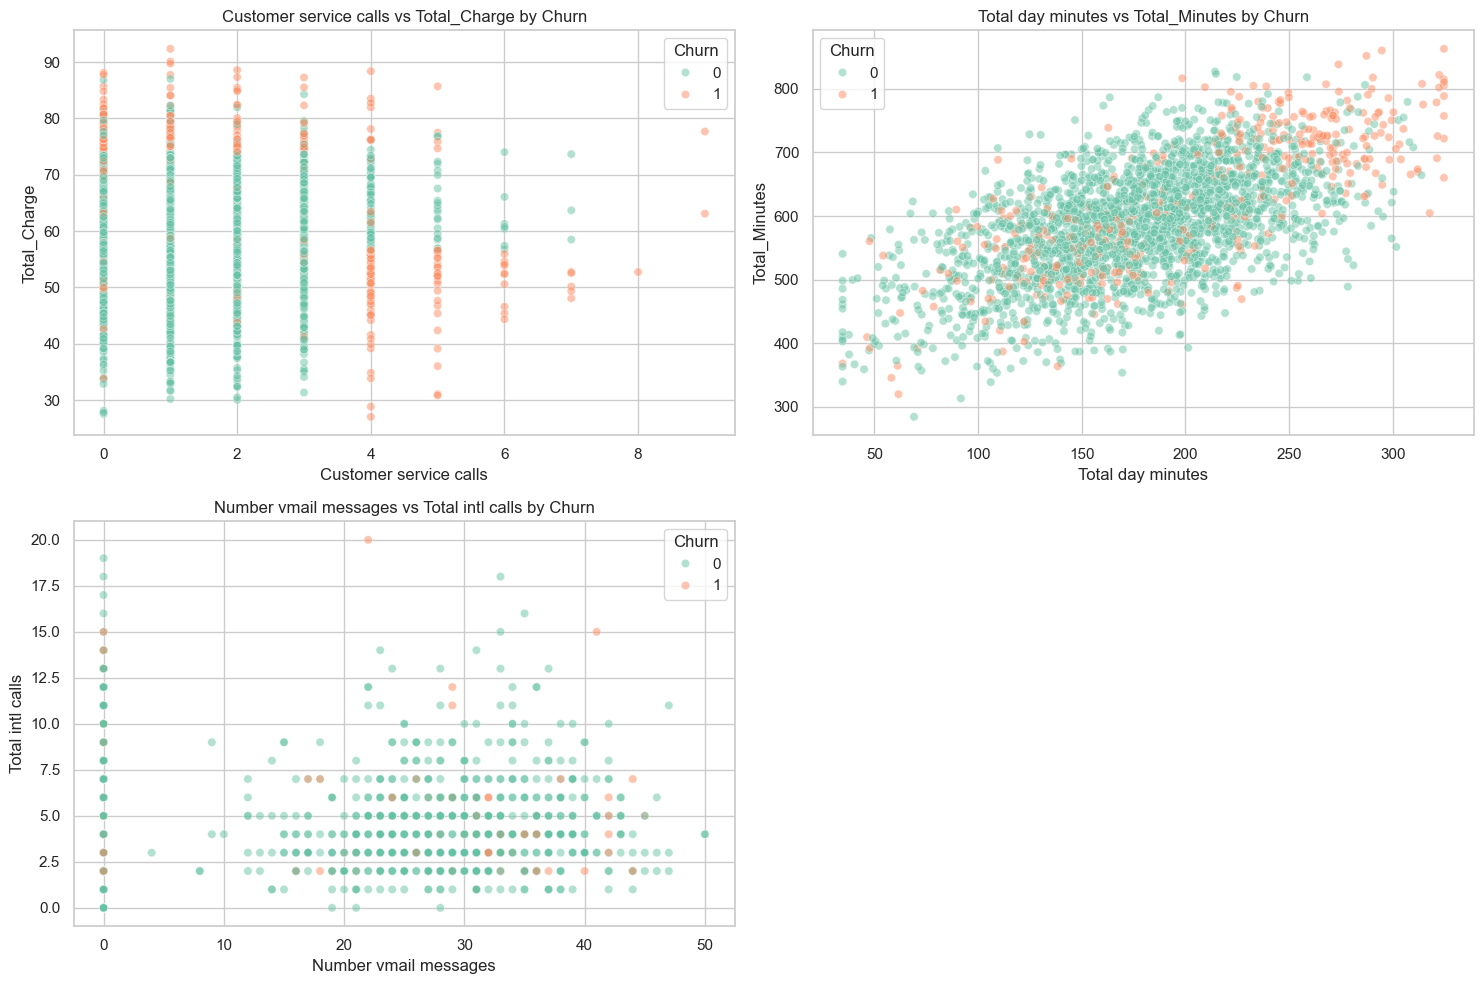

In [35]:
# Define key feature pairs based on correlation with Churn
scatter_pairs = [
    ('Customer service calls', 'Total_Charge'),
    ('Total day minutes', 'Total_Minutes'),
    ('Number vmail messages', 'Total intl calls')
]

# Set up the figure
plt.figure(figsize=(15, 10))
n_cols = 2 
n_rows = int(np.ceil(len(scatter_pairs) / n_cols)) 

# Create scatter plots
for i, (x_col, y_col) in enumerate(scatter_pairs, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.scatterplot(data=df, x=x_col, y=y_col, hue='Churn', palette='Set2', alpha=0.5)
    plt.title(f'{x_col} vs {y_col} by Churn')

plt.tight_layout()
plt.show()